# Transfer Learning

## Prepare dataloader

In [1]:
import dataset
from torchvision import transforms

# Create training transform with TrivialAugment
all_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
        train_transform=all_transform,
        test_transform=all_transform,
        validate_transform=all_transform,
    )

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(names)

['RG01 RX-78-2 Gundam', "RG02 MS-06S Char's Zaku II", 'RG03 GAT-X-105 Aile Strike Gundam', 'RG04 MS-06F Zaku II', 'RG05 ZGMF-X10A Freedom Gundam', 'RG06 FX-550 Sky Grasper', 'RG07 RX-178 Gundam Mk-II Titans', 'RG08 RX-178 Gundam Mk-II A.E.U.G.', 'RG09 ZGMF-X09A Justice Gundam', 'RG10 MSZ-006 Zeta Gundam', 'RG11 ZGMF-X42S Destiny Gundam', 'RG12 RX-78GP01 Zephyranthes', 'RG13 RX-78GP01fb Full Burnern', 'RG14 ZGMF-X20A Strike Freedom Gundam', 'RG15 GN-001 Gundam Exia', "RG16 MSM-07S Char's Z'gok", 'RG17 XXXG-00W0 Wing Gundam Zero EW', 'RG18 GN-0000-GNR-010 OO Raiser', 'RG19 MBF-P02 Gundam Astray Red Frame', 'RG20 XXXG-01W Wing Gundam EW', 'RG21 GNT-0000 OO Qan[T]', 'RG22 MSN-06S Sinanju', 'RG23 Build Strike Gundam Full Package', 'RG24 Gundam Astray Gold Frame Amatsu Mina', 'RG25 RX-0 Unicorn Gundam', "RG26 MS-06R-2 Johnny Ridden's Zaku II", 'RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn', 'RG28 OZ-00MS Tallgeese EW', 'RG29 MSN-04 Sazabi', 'RG30 RX-0 Full Armor Unicorn Gundam', 'RG31 XM-X1 C

## Hyper parameters


In [3]:
EPOCHS=20
LEARNING_RATE=0.001
OUTPUT_SIZE=len(names)

## The pretained EfficentNet Model

In [4]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b0_unargument = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [5]:
import utils
utils.summary(efficentnet_b0_unargument,
        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Freezing the base model and changing the output layer to suit our needs

In [6]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b0_unargument.features.parameters():
    param.requires_grad = False

In [7]:
import utils

utils.set_seeds()

# Recreate the classifier layer and seed it to the target device
efficentnet_b0_unargument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

In [8]:
utils.summary(efficentnet_b0_unargument,
        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train the model

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-15/efficentnet_b0_unargument...


  5%|███▊                                                                        | 1/20 [00:10<03:13, 10.19s/it]

Epoch: 1 | train_loss: 3.0032 | train_acc: 0.2829 | test_loss: 2.3543 | test_acc: 0.5365


 10%|███████▌                                                                    | 2/20 [00:19<02:55,  9.72s/it]

Epoch: 2 | train_loss: 2.0336 | train_acc: 0.6071 | test_loss: 1.8170 | test_acc: 0.6240


 15%|███████████▍                                                                | 3/20 [00:28<02:42,  9.58s/it]

Epoch: 3 | train_loss: 1.5581 | train_acc: 0.6987 | test_loss: 1.5227 | test_acc: 0.6531


 20%|███████████████▏                                                            | 4/20 [00:38<02:31,  9.45s/it]

Epoch: 4 | train_loss: 1.3026 | train_acc: 0.7394 | test_loss: 1.3782 | test_acc: 0.6948


 25%|███████████████████                                                         | 5/20 [00:47<02:21,  9.44s/it]

Epoch: 5 | train_loss: 1.1258 | train_acc: 0.7826 | test_loss: 1.2845 | test_acc: 0.6979


 30%|██████████████████████▊                                                     | 6/20 [00:57<02:13,  9.53s/it]

Epoch: 6 | train_loss: 0.9993 | train_acc: 0.8070 | test_loss: 1.2143 | test_acc: 0.7073


 35%|██████████████████████████▌                                                 | 7/20 [01:06<02:04,  9.56s/it]

Epoch: 7 | train_loss: 0.8860 | train_acc: 0.8311 | test_loss: 1.1571 | test_acc: 0.7208


 40%|██████████████████████████████▍                                             | 8/20 [01:16<01:54,  9.57s/it]

Epoch: 8 | train_loss: 0.8064 | train_acc: 0.8441 | test_loss: 1.0998 | test_acc: 0.7344


 45%|██████████████████████████████████▏                                         | 9/20 [01:25<01:43,  9.45s/it]

Epoch: 9 | train_loss: 0.7553 | train_acc: 0.8537 | test_loss: 1.0732 | test_acc: 0.7312


 50%|█████████████████████████████████████▌                                     | 10/20 [01:35<01:34,  9.44s/it]

Epoch: 10 | train_loss: 0.6907 | train_acc: 0.8745 | test_loss: 1.0359 | test_acc: 0.7417


 55%|█████████████████████████████████████████▎                                 | 11/20 [01:44<01:24,  9.44s/it]

Epoch: 11 | train_loss: 0.6477 | train_acc: 0.8815 | test_loss: 1.0257 | test_acc: 0.7365


 60%|█████████████████████████████████████████████                              | 12/20 [01:53<01:14,  9.31s/it]

Epoch: 12 | train_loss: 0.6125 | train_acc: 0.8857 | test_loss: 1.0019 | test_acc: 0.7438


 65%|████████████████████████████████████████████████▊                          | 13/20 [02:02<01:05,  9.32s/it]

Epoch: 13 | train_loss: 0.5560 | train_acc: 0.9011 | test_loss: 0.9867 | test_acc: 0.7385


 70%|████████████████████████████████████████████████████▌                      | 14/20 [02:12<00:56,  9.50s/it]

Epoch: 14 | train_loss: 0.5194 | train_acc: 0.8995 | test_loss: 0.9752 | test_acc: 0.7469


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [02:21<00:46,  9.36s/it]

Epoch: 15 | train_loss: 0.4869 | train_acc: 0.9105 | test_loss: 0.9723 | test_acc: 0.7510


 80%|████████████████████████████████████████████████████████████               | 16/20 [02:31<00:37,  9.42s/it]

Epoch: 16 | train_loss: 0.4638 | train_acc: 0.9240 | test_loss: 0.9578 | test_acc: 0.7510


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [02:40<00:28,  9.37s/it]

Epoch: 17 | train_loss: 0.4538 | train_acc: 0.9173 | test_loss: 0.9505 | test_acc: 0.7521


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [02:50<00:18,  9.34s/it]

Epoch: 18 | train_loss: 0.4492 | train_acc: 0.9216 | test_loss: 0.9256 | test_acc: 0.7604


 95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [02:59<00:09,  9.30s/it]

Epoch: 19 | train_loss: 0.4016 | train_acc: 0.9316 | test_loss: 0.9227 | test_acc: 0.7615


100%|███████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.44s/it]

Epoch: 20 | train_loss: 0.4019 | train_acc: 0.9260 | test_loss: 0.9119 | test_acc: 0.7521
Saving model to: ./models/efficentnet_b0_unargument.pt


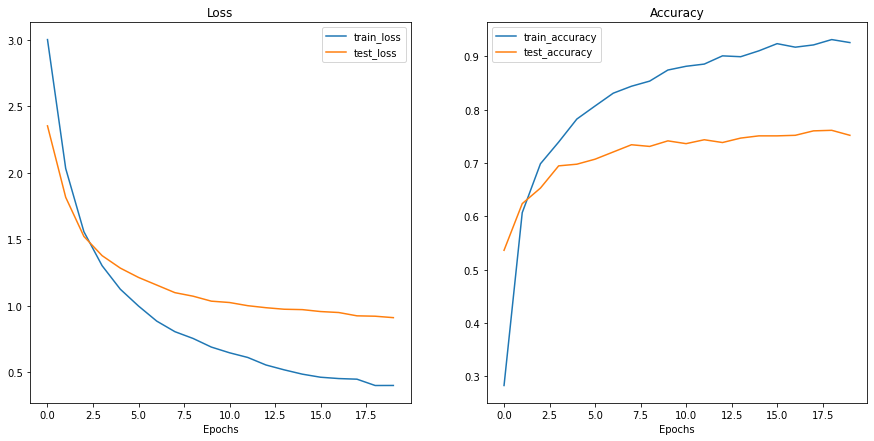

In [9]:
import utils

optimizer = torch.optim.Adam(efficentnet_b0_unargument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b0_unargument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b0_unargument",
)

## Evaluating the performance

In [10]:
import engine

metrics=engine.test_step(
    model=efficentnet_b0_unargument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(2.8805216380528043, 0.3586309523809524)


## Making predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG02/61pHukdzuXL._AC_SX679_.jpg
RG02 MS-06S Char's Zaku II : 0.611
RG16 MSM-07S Char's Z'gok : 0.161
RG09 ZGMF-X09A Justice Gundam : 0.161


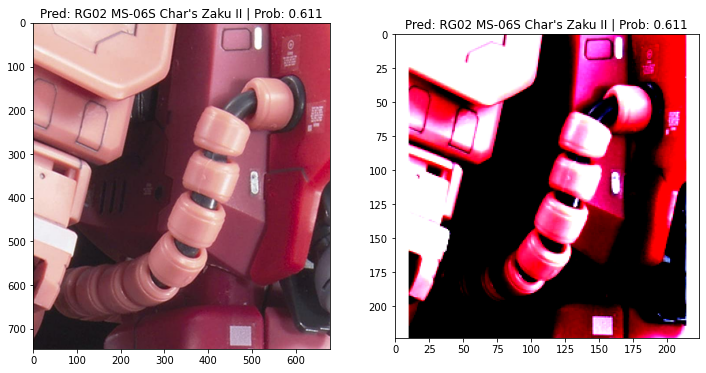

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG29/61nTumgkjXL._AC_SX679_.jpg
RG02 MS-06S Char's Zaku II : 0.325
RG09 ZGMF-X09A Justice Gundam : 0.151
RG04 MS-06F Zaku II  : 0.135


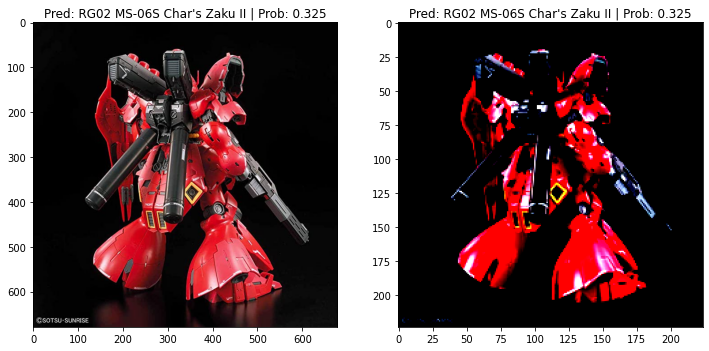

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG22/819V+LohJOL._AC_SX679_.jpg
RG10 MSZ-006 Zeta Gundam : 0.163
RG14 ZGMF-X20A Strike Freedom Gundam : 0.104
RG03 GAT-X-105 Aile Strike Gundam : 0.080


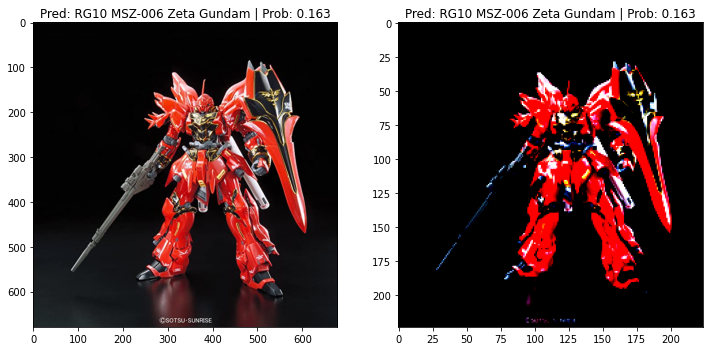

In [11]:
import data_utils
import inference

imgs=data_utils.get_random_images("./data/gunpla/validate", k=3)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=efficentnet_b0_unargument, 
        image_path=img, 
        class_names=names,
        transform=all_transform, 
        topk=3)

# EfficientNet_B2 without argument

## Creating the model

In [12]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b2_unargument = torchvision.models.efficientnet_b2(weights=weights).to(device)

utils.summary(efficentnet_b2_unargument,        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b2_unargument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b2_unargument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1408,         # note: this is different from b0
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
#torchinfo.summary(efficentnet_b2_unargument)
utils.summary(efficentnet_b2_unargument,  input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-15/efficentnet_b2_unargument...


  5%|███▊                                                                        | 1/20 [00:11<03:34, 11.26s/it]

Epoch: 1 | train_loss: 3.0872 | train_acc: 0.2572 | test_loss: 2.5419 | test_acc: 0.4969


 10%|███████▌                                                                    | 2/20 [00:22<03:24, 11.34s/it]

Epoch: 2 | train_loss: 2.1494 | train_acc: 0.5836 | test_loss: 2.0244 | test_acc: 0.5792


 15%|███████████▍                                                                | 3/20 [00:34<03:13, 11.39s/it]

Epoch: 3 | train_loss: 1.6744 | train_acc: 0.6749 | test_loss: 1.7370 | test_acc: 0.6208


 20%|███████████████▏                                                            | 4/20 [00:45<03:01, 11.37s/it]

Epoch: 4 | train_loss: 1.3939 | train_acc: 0.7292 | test_loss: 1.5703 | test_acc: 0.6531


 25%|███████████████████                                                         | 5/20 [00:56<02:49, 11.30s/it]

Epoch: 5 | train_loss: 1.2131 | train_acc: 0.7631 | test_loss: 1.4660 | test_acc: 0.6656


 30%|██████████████████████▊                                                     | 6/20 [01:07<02:38, 11.31s/it]

Epoch: 6 | train_loss: 1.0458 | train_acc: 0.7968 | test_loss: 1.3910 | test_acc: 0.6833


 35%|██████████████████████████▌                                                 | 7/20 [01:19<02:26, 11.30s/it]

Epoch: 7 | train_loss: 0.9721 | train_acc: 0.8108 | test_loss: 1.3278 | test_acc: 0.6781


 40%|██████████████████████████████▍                                             | 8/20 [01:30<02:15, 11.31s/it]

Epoch: 8 | train_loss: 0.8572 | train_acc: 0.8403 | test_loss: 1.2844 | test_acc: 0.6906


 45%|██████████████████████████████████▏                                         | 9/20 [01:42<02:05, 11.37s/it]

Epoch: 9 | train_loss: 0.7986 | train_acc: 0.8505 | test_loss: 1.2456 | test_acc: 0.6865


 50%|█████████████████████████████████████▌                                     | 10/20 [01:53<01:53, 11.35s/it]

Epoch: 10 | train_loss: 0.7479 | train_acc: 0.8557 | test_loss: 1.2186 | test_acc: 0.6833


 55%|█████████████████████████████████████████▎                                 | 11/20 [02:04<01:41, 11.29s/it]

Epoch: 11 | train_loss: 0.6907 | train_acc: 0.8660 | test_loss: 1.1982 | test_acc: 0.6917


 60%|█████████████████████████████████████████████                              | 12/20 [02:15<01:30, 11.33s/it]

Epoch: 12 | train_loss: 0.6599 | train_acc: 0.8710 | test_loss: 1.1690 | test_acc: 0.7010


 65%|████████████████████████████████████████████████▊                          | 13/20 [02:27<01:19, 11.36s/it]

Epoch: 13 | train_loss: 0.5876 | train_acc: 0.8945 | test_loss: 1.1383 | test_acc: 0.7021


 70%|████████████████████████████████████████████████████▌                      | 14/20 [02:39<01:08, 11.45s/it]

Epoch: 14 | train_loss: 0.5586 | train_acc: 0.8909 | test_loss: 1.1435 | test_acc: 0.6927


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [02:50<00:56, 11.39s/it]

Epoch: 15 | train_loss: 0.5300 | train_acc: 0.9079 | test_loss: 1.1240 | test_acc: 0.7031


 80%|████████████████████████████████████████████████████████████               | 16/20 [03:01<00:45, 11.49s/it]

Epoch: 16 | train_loss: 0.5014 | train_acc: 0.9084 | test_loss: 1.1130 | test_acc: 0.7031


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [03:13<00:34, 11.47s/it]

Epoch: 17 | train_loss: 0.4897 | train_acc: 0.9056 | test_loss: 1.1114 | test_acc: 0.7021


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [03:24<00:22, 11.43s/it]

Epoch: 18 | train_loss: 0.4546 | train_acc: 0.9151 | test_loss: 1.0893 | test_acc: 0.7031


 95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [03:36<00:11, 11.44s/it]

Epoch: 19 | train_loss: 0.4697 | train_acc: 0.9086 | test_loss: 1.0906 | test_acc: 0.7083


100%|███████████████████████████████████████████████████████████████████████████| 20/20 [03:47<00:00, 11.38s/it]

Epoch: 20 | train_loss: 0.4120 | train_acc: 0.9264 | test_loss: 1.1036 | test_acc: 0.6990
Saving model to: ./models/efficentnet_b2_unargument.pt


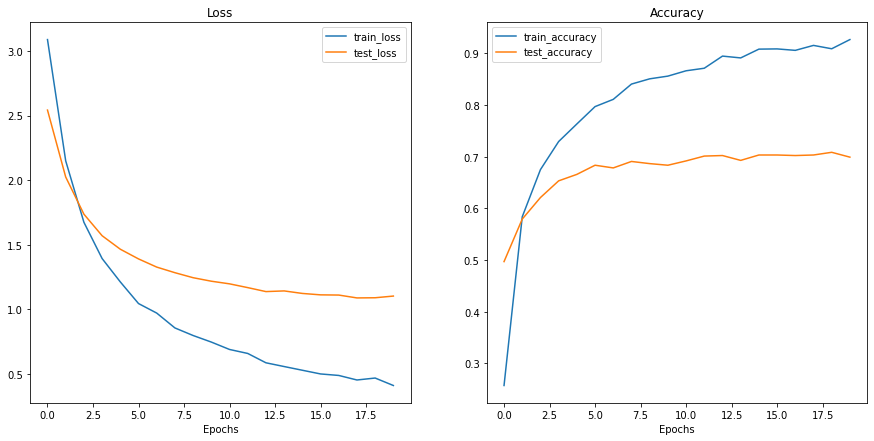

In [14]:
optimizer = torch.optim.Adam(efficentnet_b2_unargument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b2_unargument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b2_unargument",
)

## Evaluate

In [15]:
metrics=engine.test_step(
    model=efficentnet_b0_unargument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(2.6422782284872874, 0.41666666666666663)


# EfficientNet_B0 with argument

## Creating the dataloaders

In [16]:
import dataset
from torchvision import transforms

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
        train_transform=train_transform,
        test_transform=test_validate_transform,
        validate_transform=test_validate_transform,
    )

## Creating the model

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b0_argument = torchvision.models.efficientnet_b0(weights=weights).to(device)

utils.summary(efficentnet_b0_argument, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [18]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b0_argument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b0_argument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
utils.summary(efficentnet_b0_argument,  input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training

In [ ]:
optimizer = torch.optim.Adam(efficentnet_b0_argument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b0_argument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b0_argument",
)

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-15/efficentnet_b0_argument...


  5%|███▊                                                                        | 1/20 [00:10<03:21, 10.60s/it]

Epoch: 1 | train_loss: 3.1840 | train_acc: 0.1953 | test_loss: 2.5013 | test_acc: 0.5052


 10%|███████▌                                                                    | 2/20 [00:21<03:14, 10.82s/it]

Epoch: 2 | train_loss: 2.4000 | train_acc: 0.4714 | test_loss: 1.9501 | test_acc: 0.5833


 15%|███████████▍                                                                | 3/20 [00:32<03:03, 10.79s/it]

Epoch: 3 | train_loss: 2.0639 | train_acc: 0.5305 | test_loss: 1.6594 | test_acc: 0.6385


 20%|███████████████▏                                                            | 4/20 [00:43<02:52, 10.78s/it]

Epoch: 4 | train_loss: 1.8473 | train_acc: 0.5654 | test_loss: 1.5104 | test_acc: 0.6510


 25%|███████████████████                                                         | 5/20 [00:53<02:41, 10.78s/it]

Epoch: 5 | train_loss: 1.6469 | train_acc: 0.6259 | test_loss: 1.3655 | test_acc: 0.6792


 30%|██████████████████████▊                                                     | 6/20 [01:04<02:30, 10.76s/it]

Epoch: 6 | train_loss: 1.5544 | train_acc: 0.6297 | test_loss: 1.2955 | test_acc: 0.6990


## Evaluate

In [ ]:
metrics=engine.test_step(
    model=efficentnet_b0_argument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

# EfficientNet_B2 with argument

## Creating the model

In [ ]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b2_argument = torchvision.models.efficientnet_b2(weights=weights).to(device)

utils.summary(efficentnet_b2_argument,        input_size=(32, 3, 224, 224))

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b2_argument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b2_argument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1408,         # note: this is different from b0
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
#torchinfo.summary(efficentnet_b2_unargument)
utils.summary(efficentnet_b2_argument,  input_size=(32, 3, 224, 224))

## Training

In [ ]:
optimizer = torch.optim.Adam(efficentnet_b2_argument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b2_argument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b2_argument",
)

## Evaluate

In [ ]:
metrics=engine.test_step(
    model=efficentnet_b2_argument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

# Compare different models

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

# Predicting with best preformance model

In [ ]:
imgs=data_utils.get_random_images("./data/gunpla/validate", k=9)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=efficentnet_b0_unargument, 
        image_path=img, 
        class_names=names,
        transform=all_transform, 
        topk=3)